## How models get fit

##### 2025.04.07-2025.04.11

### Least (mean) squares

Given a matrix $X\in\mathbb{R}^{n\times p}$ and a vector $y\in\mathbb{R}^n$,
find the vector $\beta\in\mathbb{R}^p$ that minimizes
$$
\operatorname{MSE}=\text{mean squared error}=\frac1n\|y - X\beta\|^2.
$$

If $X$ has rank $p$ (a linear algebraic nondegeneracy condition when $p\leq n$), then this optimization problem has an unique solution. Moreover, this solution has a closed-form solution:
$$
\beta = (X^TX)^{-1}X^Ty
$$


In [550]:
import numpy as np
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True)
size, p = X.shape
print(f"n = {size}, p = {p}")
assert len(y) == size

beta = np.linalg.inv(X.T @ X) @ X.T @ y
beta

n = 442, p = 10


array([ -10.0098663 , -239.81564367,  519.84592005,  324.3846455 ,
       -792.17563855,  476.73902101,  101.04326794,  177.06323767,
        751.27369956,   67.62669218])

Let's check that our $\beta$ agrees with Scikit Learn's:

In [551]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)
model.fit(X, y)  # type: ignore
assert np.allclose(beta, model.coef_)

A simple closed form expression for the $\beta$ is unique to linear regression.

There is no such for logistic, Poisson, or negative binomial regression. Nor for random effects models beyond the simplest variants.

We rely on iterative algorithms that produce convengent sequences of approximations.

The simplest algorithm for minimizing a function is gradient descent.

### Gradients (derivatives)

- We're given a real-valued function $f$ on vectors $\beta\in\mathbb{R}^p$ that we want to minimize it.

- Calculus furnishes us with a distinguished function $\nabla f$ with values in $\mathbb{R}^p$ called the ***gradient of $f$***.

- $\nabla f(\beta)$ has the ***descent property***: If $\nabla f(\beta)\neq 0$, then 
  $$
  f\big(\beta - h\nabla f(\beta)\big) < f(\beta)
  $$
  for sufficiently small, positive $h$.

### The gradient descent algorithm

##### Input
- $f$, the function we want to minimize
- $h$, a step size
- $\beta$, randomly initialized vector

##### Output
- Hopefully, an approximate minimizer $\beta'$ of $f$:
$$
f(\beta')\approx \min_\beta f(\beta)
$$

##### Algorithm
1. Set $\beta'=\beta - h\nabla f(\beta)$.

2. If $f(\beta')\approx f(\beta)$, return $\beta'$. Otherwise, return to 1.

### JAX: NumPy + gradients

In [552]:
import jax.numpy as jnp
from jax import grad, value_and_grad

X, y = load_diabetes(return_X_y=True)
size, p = X.shape


def mse(beta):
    return jnp.mean((y - X @ beta) ** 2)

In [553]:
beta = jnp.array(np.random.uniform(size=p))
print(f"mse(beta) = {mse(beta)}")
print(f"grad(mse)(beta) = {grad(mse)(beta)}")

v, g = value_and_grad(mse)(beta)
print(f"\nv = {v}")
print(f"g = {g}")

mse(beta) = 29065.8125
grad(mse)(beta) = [-1.3722459  -0.31320122 -4.2902155  -3.227192   -1.5454077  -1.2685142
  2.8900678  -3.1469736  -4.1378827  -2.7954698 ]

v = 29065.8125
g = [-1.3722459  -0.31320122 -4.2902155  -3.227192   -1.5454077  -1.2685142
  2.8900678  -3.1469736  -4.1378827  -2.7954698 ]


In [554]:
h = 100.0
max_iter = 3000
beta = jnp.array(np.random.uniform(size=p))
for i in range(max_iter):
    v, g = value_and_grad(mse)(beta)
    if i % 500 == 0:
        print(f"i = {i}: mse(beta) = {v}")
    beta -= h * g
print(f"\nbeta = {beta}")

i = 0: mse(beta) = 29066.29296875
i = 500: mse(beta) = 26004.755859375
i = 1000: mse(beta) = 26004.3046875
i = 1500: mse(beta) = 26004.294921875
i = 2000: mse(beta) = 26004.296875
i = 2500: mse(beta) = 26004.29296875

beta = [ -10.009933 -239.8156    519.846     324.38474  -792.1676    476.73227
  101.04023   177.06308   751.2704     67.626884]


Scikit Learn model coefficients (copied and pasted from above):
```text
array([ -10.0098663 , -239.81564367,  519.84592005,  324.3846455 ,
       -792.17563855,  476.73902101,  101.04326794,  177.06323767,
        751.27369956,   67.62669218])
```

### Logistic regression

- Instead of minimizing MSE, we minimize ***log-loss***:
$$
L(\beta) = \frac1n\left(\sum_{i<n}\big(-y_i\log p_i - (1 - y_i)\log(1 - p_i)\big)\right),
\qquad p_i = \frac1{1 + e^{-X\beta}}
$$

Using the identities,
$$
\log p_i = -\log(1 + e^{-X\beta})\qquad\text{and}\qquad \log(1 - p_i) = -\log(1 + e^{X\beta})
$$
we get
$$
L(\beta) = \frac1n\left(\sum_{i<n}\big(y_i\log (1 + e^{-X\beta}) + (1 - y_i)\log(1 + e^{X\beta})\big)\right).
$$

##### Remark

The function $f(x)=-\log(1 + e^{-x})$ is called the ***log-sigmoid function***.

In [556]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

size = 200
p = 10
rng = np.random.default_rng(42)
X = rng.normal(size=(size, p))
beta_true = rng.normal(size=p)
probs = 1 / (1 + np.exp(-X @ beta_true))
y = (rng.random(size=size) < probs).astype(int)


model = LogisticRegression(C=np.inf, max_iter=1000, fit_intercept=False)
model.fit(X, y)  # type: ignore
loss = log_loss(y, model.predict_proba(X)[:, 1])
print(f"model.coef_.round(2) = {model.coef_.squeeze().round(2)}")
print(f"\nloss = {loss}")

model.coef_.round(2) = [-0.68 -0.46  0.4   0.25 -1.3   0.76 -0.43 -1.29  1.65  0.78]

loss = 0.3745998184276785


In [557]:
def my_log_loss(beta):
    return jnp.mean(y * jnp.log(1 + jnp.exp(-X @ beta)) + (1 - y) * jnp.log(1 + jnp.exp(X @ beta)))  # type: ignore


h = 10
max_iter = 50
beta = jnp.array(np.random.normal(size=p))  # type: ignore
for i in range(max_iter):
    v, g = value_and_grad(my_log_loss)(beta)
    if i % 10 == 0:
        print(f"i = {i}: my_log_loss(beta) = {v}")
    beta -= h * g
print(f"\nbeta.round(2) = {np.array(beta).round(2)}")

i = 0: my_log_loss(beta) = 1.0123999118804932
i = 10: my_log_loss(beta) = 0.37464815378189087
i = 20: my_log_loss(beta) = 0.3745999038219452
i = 30: my_log_loss(beta) = 0.37459975481033325
i = 40: my_log_loss(beta) = 0.37459975481033325

beta.round(2) = [-0.68 -0.46  0.4   0.25 -1.3   0.76 -0.43 -1.29  1.65  0.78]


The log-sigmoid function is built into JAX. We can use it.

In [558]:
from jax.nn import log_sigmoid


def my_log_loss(beta):
    return -jnp.mean(y * log_sigmoid(X @ beta) + (1 - y) * log_sigmoid(-X @ beta))


h = 10
max_iter = 50
beta = jnp.array(np.random.normal(size=p))  # type: ignore
for i in range(max_iter):
    v, g = value_and_grad(my_log_loss)(beta)
    if i % 10 == 0:
        print(f"i = {i}: my_log_loss(beta) = {v}")
    beta -= h * g
print(f"\nbeta.round(2) = {np.array(beta).round(2)}")

i = 0: my_log_loss(beta) = 1.6029266119003296
i = 10: my_log_loss(beta) = 0.37462809681892395
i = 20: my_log_loss(beta) = 0.37459999322891235
i = 30: my_log_loss(beta) = 0.37459975481033325
i = 40: my_log_loss(beta) = 0.37459975481033325

beta.round(2) = [-0.68 -0.46  0.4   0.25 -1.3   0.76 -0.43 -1.29  1.65  0.78]


### Softmax regression

$$
\frac{p(v_j\mid \beta)}{p(v_0\mid \beta)} = e^{X\beta_j},\qquad 0 < j < n\tag{$\dag$}
$$

Solving
$$
\frac1{p(v_0\mid\beta)} =\sum_k \frac{p(v_k\mid \beta)}{p(v_0\mid\beta)} = \sum_k e^{X\beta_k}
$$
for $p(v_0\mid\beta)$, we get
$$
p(v_0\mid\beta) = \frac1{\sum_j e^{X\beta_j}}.
$$

Letting $\beta_0=0$ (the zero vector), we have
$$
p(v_j\mid\beta)=\frac{e^{X\beta_j}}{\sum_ke^{X\beta_k}}
$$
for all $j$.

Define the ***softmax function***:
$$
\operatorname{softmax}:\mathbb{R}^c\longrightarrow \mathbb{R}^c,\qquad
\operatorname{softmax}(\mu) = \left(
    \frac{e^{\mu_0}}{\sum_k e^{\mu_k}},\ldots, \frac{e^{\mu_{c-1}}}{\sum_k e^{\mu_k}}
\right)
$$

log-likelihood function:
$$
\log p(y_i\mid x_i, \beta) = \operatorname{sum}(y_i\odot\log\operatorname{softmax}(x_i\beta))
$$

Batched version:
$$
\log p(Y\mid X,\beta) = \operatorname{sum}(Y\odot\log\operatorname{softmax}(X\beta,\, \text{\texttt{axis=1}}),\, \text{\texttt{axis=1}})
$$

Conveniently, the log-softmax function is built into JAX.

In [564]:
from sklearn.metrics import accuracy_score

size = 300
p = 10
c = 4
rng = np.random.default_rng(42)
X = rng.normal(size=(size, p))
beta = rng.normal(size=(p, c))
z = np.exp(X @ beta)
probs = z / z.sum(axis=1, keepdims=True)
y = np.argmax(rng.uniform(size=(size, 1)) < np.cumsum(probs, axis=1), axis=1)

model = LogisticRegression(C=np.inf, max_iter=1000, fit_intercept=False, tol=1e-8)
model.fit(X, y)  # type: ignore
accuracy_score(y, model.predict(X))

print(model.coef_.squeeze().round(2).T)

[[ 0.84 -0.16  1.12 -1.79]
 [ 0.3  -0.13 -1.56  1.39]
 [-0.66  0.03  1.44 -0.81]
 [-0.54  0.22  0.82 -0.5 ]
 [-0.1   1.41  0.41 -1.72]
 [-1.16  1.3   0.45 -0.59]
 [-0.02  0.4   0.88 -1.25]
 [-0.74  0.05 -0.02  0.72]
 [-1.54  0.34  0.73  0.47]
 [ 0.27  0.36 -0.61 -0.02]]


In [565]:
from jax.nn import log_softmax

Y = np.zeros((size, c))
np.put_along_axis(arr=Y, indices=y.reshape(-1, 1), values=1, axis=1)


def loss(beta):
    return -jnp.sum(Y * log_softmax(X @ beta)) / size


h = 10
max_iter = 30
beta = jnp.array(np.random.normal(size=(p, c)))  # type: ignore
for i in range(max_iter):
    v, g = value_and_grad(loss)(beta)
    if i % 2 == 0:
        print(f"i = {i}: loss(beta) = {v}")
    beta -= h * g
print(f"\nbeta.round(2) = {np.array(beta).round(2)}")

i = 0: loss(beta) = 3.732680559158325
i = 2: loss(beta) = 0.5561644434928894
i = 4: loss(beta) = 0.5440211892127991
i = 6: loss(beta) = 0.542653501033783
i = 8: loss(beta) = 0.5423337817192078
i = 10: loss(beta) = 0.5422449111938477
i = 12: loss(beta) = 0.5422179102897644
i = 14: loss(beta) = 0.5422090291976929
i = 16: loss(beta) = 0.542205810546875
i = 18: loss(beta) = 0.5422044992446899
i = 20: loss(beta) = 0.5422039031982422
i = 22: loss(beta) = 0.5422036051750183
i = 24: loss(beta) = 0.5422035455703735
i = 26: loss(beta) = 0.542203426361084
i = 28: loss(beta) = 0.542203426361084

beta.round(2) = [[ 1.13  0.13  1.42 -1.5 ]
 [ 0.3  -0.13 -1.55  1.4 ]
 [-1.27 -0.59  0.83 -1.42]
 [-1.27 -0.51  0.1  -1.22]
 [-0.4   1.11  0.11 -2.02]
 [-1.85  0.61 -0.23 -1.28]
 [-0.41  0.01  0.49 -1.64]
 [-0.59  0.2   0.14  0.87]
 [-1.62  0.26  0.65  0.39]
 [-0.34 -0.26 -1.22 -0.64]]


In [566]:
model = LogisticRegression(fit_intercept=False)
model.fit(X, y)
model.coef_.round(2).T

array([[ 0.74, -0.19,  0.95, -1.51],
       [ 0.21, -0.05, -1.29,  1.13],
       [-0.53, -0.04,  1.24, -0.67],
       [-0.45,  0.16,  0.7 , -0.41],
       [-0.04,  1.17,  0.28, -1.42],
       [-0.96,  1.1 ,  0.35, -0.48],
       [-0.02,  0.31,  0.74, -1.04],
       [-0.63,  0.02, -0.01,  0.62],
       [-1.3 ,  0.26,  0.6 ,  0.44],
       [ 0.22,  0.33, -0.51, -0.03]])

In [570]:
from sklearn.metrics import accuracy_score

beta_skl = model.coef_.round(2).T
loss(beta_skl)
accuracy_score(y, model.predict(X))

0.76

In [573]:
y_pred = np.argmax(X @ beta, axis=1)
accuracy_score(y, y_pred)

0.76

### This time using identifiable parameters

In [ ]:
def data(n: int, p: int, c: int, rng: int | np.random.Generator | None = None):
    if c < 2:
        raise ValueError("Number of classes c must be > 1.")
    rng = np.random.default_rng(rng)
    X = rng.normal(size=(n, p))
    beta = np.zeros((p, c))
    beta[:, 1:] = rng.normal(size=(p, c - 1))
    z = np.exp(X @ beta)
    probs = z / z.sum(axis=1, keepdims=True)
    y = np.argmax(
        rng.uniform(size=(n, 1)) < np.cumsum(probs, axis=1), axis=1, keepdims=True
    )
    Y = np.zeros((n, c))
    np.put_along_axis(arr=Y, indices=y, values=1, axis=1)
    return X, Y, beta[:, 1:]


def model(beta, X):
    p = len(beta)
    full_beta = jnp.hstack([jnp.zeros((p, 1)), beta])
    logits = X @ full_beta
    return logits


def loss(beta, X, Y):
    logits = model(beta, X)
    return -jnp.sum(Y * log_softmax(logits)) / size

In [ ]:
size = 10000000
p = 10
c = 4
X, Y, _beta = data(size, p, c)
print(
    f"true loss = {np.mean(
        np.argmax(X @ np.hstack([np.zeros((p, 1)), _beta]), axis=1)
        == np.argmax(Y, axis=1)
    ):.4f}"
)

h = 10
max_iter = 50
beta = jnp.array(np.random.normal(size=(p, c - 1)))
for i in range(max_iter):
    v, g = value_and_grad(loss, 0)(beta, X, Y)
    if i % 5 == 0:
        print(f"i = {i}: loss(beta) = {v}")
    beta -= h * g

print(
    f"training loss = {np.mean(
        np.argmax(X @ np.hstack([np.zeros((p, 1)), beta]), axis=1)
        == np.argmax(Y, axis=1)
    ):.4f}"
)

assert np.all(np.sign(beta) == np.sign(_beta))
print(
    f"max error = {100*np.max((beta - _beta) / (0.5 * np.abs(beta + _beta))).item():.2f}%"
)

true loss = 0.7099
i = 0: loss(beta) = 3.6220591068267822
i = 5: loss(beta) = 0.7253149151802063
i = 10: loss(beta) = 0.714459240436554
i = 15: loss(beta) = 0.7138931155204773
i = 20: loss(beta) = 0.7138315439224243
i = 25: loss(beta) = 0.7138221263885498
i = 30: loss(beta) = 0.7138205170631409
i = 35: loss(beta) = 0.7138200998306274
i = 40: loss(beta) = 0.7138200998306274
i = 45: loss(beta) = 0.7138200998306274
training loss = 0.7099
max error = 1.93%


### Poisson regression

$$
y_i\sim \operatorname{Poisson}(e^{x_i\beta})
$$

$$
p(y_i\mid x_i,\beta) = \frac{e^{y_ix_i\beta}e^{-e^{x_i\beta}}}{y_i!}
$$

$$
\begin{aligned}
\log p(y_i\mid x_i,\beta) &= \log\frac{e^{y_ix_i\beta}e^{-e^{x_i\beta}}}{y_i!}\\
&= y_ix_i\beta - e^{x_i\beta} - \log y_i!
\end{aligned}
$$

Since $y_i!$ is gigantic is $y_i$ is big, and we only want its logarithm anyways, it's best to avoid computing directly. Better to use the ***log-gamma function***:
$$
\log y_i! = \log\Gamma(y_i + 1)
$$

Negative log-likelihood:
$$
\ell(\beta) = -\frac1n\operatorname{sum}(Y\odot (X\beta) - e^{X\beta} - \log \Gamma(Y+1))
$$

We can actually drop the log-gamma term since it doesn't depend on $\beta$.

$$
\operatorname{loss} = -\operatorname{mean}(Y\odot (X\beta) - e^{X\beta})
$$



In [404]:
def data(n: int, p: int, rng: int | np.random.Generator | None = None):
    rng = np.random.default_rng(rng)
    X = rng.normal(size=(n, p))
    beta = rng.normal(size=p)
    lam = np.exp(X @ beta)
    y = rng.poisson(lam).astype(float)
    return X, y, beta


def loss(beta, X, y):
    log_lam = X @ beta
    return -jnp.mean(y * log_lam - jnp.exp(log_lam))

In [ ]:
size = 1000000
p = 3
X, y, _beta = data(size, p)
print(f"true loss = {loss(_beta, X, y):.4f}")

h = 0.01
max_iter = 500
beta = jnp.array(np.random.normal(size=p))
# beta = jnp.zeros(p)
for i in range(max_iter):
    v, g = value_and_grad(loss, 0)(beta, X, y)
    if i % 50 == 0:
        print(f"i = {i}: loss(beta) = {v}")
    beta -= h * g
print(f"training loss = {loss(beta, X, y):.4f}")

true loss = -6.6776
i = 0: loss(beta) = -0.44397902488708496
i = 50: loss(beta) = -6.603349685668945
i = 100: loss(beta) = -6.676112651824951
i = 150: loss(beta) = -6.677542686462402
i = 200: loss(beta) = -6.677570819854736
i = 250: loss(beta) = -6.677570343017578
i = 300: loss(beta) = -6.677570819854736
i = 350: loss(beta) = -6.677570819854736
i = 400: loss(beta) = -6.677570819854736
i = 450: loss(beta) = -6.677570819854736
training loss = -6.6776


### Negative binomial regression

#### $(r, p)$-parametrization

$$
\begin{aligned}
p(y\mid n, p) &= \binom{y + n - 1}{y}(1 - p)^yp^n\\
&\propto\frac{\Gamma(y + n)}{\Gamma(n)}(1 - p)^yp^n\\
\end{aligned}
$$

$$
\begin{aligned}
\log p(y\mid n, p) &\propto  \log\Gamma(y + n) - \log\Gamma(n) + y\log(1 - p) + n\log p
\end{aligned}
$$



$$
\mu = \mathbb{E}[y] = \frac{n(1-p)}{p},\qquad
\sigma^2=\mathbb{V}[y] = \frac{n(1-p)}{p^2} = \mu + \frac{\mu^2}{n}
$$

Solve for $p$ in terms of $\mu$ and $n$,
$$
p = \frac{n}{\mu + n},
$$
note that
$$
1 - p = \frac{\mu}{\mu + n},
$$
and eliminate $p$ entirely:
$$
\begin{aligned}
p(y\mid \mu, n) &= \binom{y + n - 1}{y}
\left(\frac{\mu}{\mu + n}\right)^y
\left(\frac{n}{\mu + n}\right)^n\\
&= \frac{\Gamma(y + n)}{y!\Gamma(n)}
\left(\frac{\mu}{\mu + n}\right)^y
\left(\frac{n}{\mu + n}\right)^n
\end{aligned}
$$

$$
\begin{aligned}
\log p(y\mid \mu, n) &= \log\Gamma(y + n) - \log\Gamma(n) - \log y!\\
&\phantom{=}{} + y\log\mu - (y + n)\log(\mu + n) + n\log n
\end{aligned}
$$

sample mean = 8.04, distribution mean = 8.00
sample variance = 24.28, distribution variance = 24.00


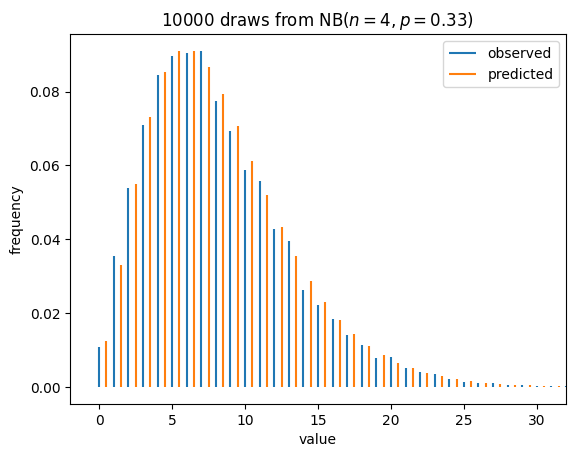

In [ ]:
import jax.scipy.stats as jstats
from collections import Counter
from matplotlib import pyplot as plt

rng = np.random.default_rng()

p = 1 / 3
size = 4
size = 10_000

# negative binomial sampling with numpy.random
# no equivalent in jax.numpy.random
y = rng.negative_binomial(size, p, size=size)
counter = Counter(y)
values = np.array(list(counter.keys()))
counts = np.array(list(counter.values()))

print(f"sample mean = {y.mean():.2f}, distribution mean = {size*(1-p)/p:.2f}")
print(f"sample variance = {y.var():.2f}, distribution variance = {size*(1-p)/p**2:.2f}")

# compute pmf-values using jax.scipy.stats.nbinom
masses = jstats.nbinom.pmf(values, size, p)

plt.vlines(values, 0, counts / size, colors="C0", label="observed")
plt.vlines(values + 0.5, 0, masses, colors="C1", label="predicted")
plt.title(f"{size} draws from $\\operatorname{{NB}}(n={size}, p={p:.2f})$")
plt.xlabel("value")
plt.ylabel("frequency")
plt.xlim(-2, 32)
plt.legend()
plt.show()

In [ ]:
def loss(beta, y):
    n, p = beta
    return -jstats.nbinom.logpmf(y, n, p).mean()


def data(size: int, n: float | None = None, p: float | None = None, rng=None):
    if n is None or p is None:
        raise ValueError()
    rng = np.random.default_rng(rng)
    return rng.negative_binomial(n, p, size=size)

In [ ]:
y = data(10000, n=4, p=1 / 3)
_beta = jnp.array([4, 1 / 3])
print(f"true loss = {loss(_beta, y):.4f}")

beta = jnp.array([1.0, 0.5])
h = 0.032
max_iter = 10000
for i in range(max_iter):
    v, g = value_and_grad(loss, 0)(beta, y)
    if i % 200 == 0:
        print(
            f"i = {i}: loss(beta) = {v}, n = {beta[0].item():.4f}, p = {beta[1].item():.4f}"
        )
    beta -= h * g
print(f"training loss = {loss(beta, y):.4f}")

size = beta[0].item()
p = beta[1].item()
print(f"n = {size:.4f}, p = {p:.4f}")

true loss = 2.9209
i = 0: loss(beta) = 6.2822699546813965, n = 1.0000, p = 0.5000
i = 200: loss(beta) = 2.9688873291015625, n = 2.1759, p = 0.2279
i = 400: loss(beta) = 2.944277048110962, n = 2.5085, p = 0.2372
i = 600: loss(beta) = 2.9359540939331055, n = 2.7379, p = 0.2534
i = 800: loss(beta) = 2.931231737136841, n = 2.9109, p = 0.2652
i = 1000: loss(beta) = 2.9282848834991455, n = 3.0478, p = 0.2743
i = 1200: loss(beta) = 2.92632794380188, n = 3.1593, p = 0.2815
i = 1400: loss(beta) = 2.9249696731567383, n = 3.2522, p = 0.2874
i = 1600: loss(beta) = 2.9239964485168457, n = 3.3309, p = 0.2923
i = 1800: loss(beta) = 2.9232850074768066, n = 3.3982, p = 0.2965
i = 2000: loss(beta) = 2.9227511882781982, n = 3.4565, p = 0.3000
i = 2200: loss(beta) = 2.9223477840423584, n = 3.5072, p = 0.3031
i = 2400: loss(beta) = 2.922037363052368, n = 3.5517, p = 0.3058
i = 2600: loss(beta) = 2.9217963218688965, n = 3.5910, p = 0.3081
i = 2800: loss(beta) = 2.9216060638427734, n = 3.6257, p = 0.3102
i =

In [543]:
mu = y.mean()
sigma = y.std()

mom_n = mu**2 / (sigma**2 - mu)
mom_p = mom_n / (mu + mom_n)
print(f"mom n = {mom_n:.4f}, mom p = {mom_p:.4f}")

mom n = 3.8758, mom p = 0.3246


In [ ]:
def data(
    n_examples: int,
    n_features: int,
    n: float,
    rng: int | np.random.Generator | None = None,
):
    if n <= 0:
        raise ValueError("n must be positive.")
    rng = np.random.default_rng(rng)
    X = rng.normal(size=(n_examples, n_features))
    beta = rng.normal(size=n_features)
    mu = np.exp(X @ beta)
    p = n / (mu + n)
    y = rng.negative_binomial(n, p)
    return X, y, beta

In [548]:
X, y, beta = data(300, 5, 4)

In [549]:
y

array([ 5,  3,  1,  1,  4,  0,  1,  1,  0,  1,  0,  0,  0,  0,  0, 18,  3,
        5,  0,  0,  0,  1,  0,  0,  7,  1, 10,  0,  1,  1,  0, 31,  0,  0,
        0,  0, 16,  4,  0,  0,  6,  0,  4,  1,  0,  0,  4,  0,  3,  0,  9,
        1,  2,  1,  4,  4,  9,  2,  0,  1,  4,  0,  3,  2,  3,  1, 19,  1,
        0,  1,  2,  0,  0, 12,  0,  0,  2,  0,  0,  0,  0,  0,  3,  0,  0,
        3,  4,  1,  0,  0,  0,  0,  3,  6,  2,  2,  0,  1,  0,  2,  9,  2,
        0,  2,  2,  0,  0,  1,  0,  8,  1,  4,  2,  3,  0,  0,  1,  0,  2,
        1,  4, 24,  0,  1,  2,  4,  3,  0,  0,  0,  0,  0,  1,  5,  3,  0,
       12,  3,  3,  1,  7,  0,  0,  0, 10,  1,  0,  1,  2,  0, 23,  1,  0,
        0,  0,  5,  1,  3,  1,  2,  0,  1, 22,  0,  1,  0,  0, 68, 11,  1,
        1,  6,  0,  0,  0,  0,  0,  0,  1,  6,  6,  1,  2,  2,  0,  6,  0,
        0, 10,  0,  0,  6,  0,  1,  0, 29,  7,  0,  3,  0,  2, 13,  1,  1,
        0,  1,  2,  2,  0,  0,  1,  1,  1,  0,  3,  0,  0,  0,  6,  0,  9,
        2,  1,  0,  0,  1